# Research Software Engineering
--------------------------------
## Real Estate Price Analysis

### Why this topic?
House price prediction is of significant importance in today's world. It plays a crucial role in financial planning for individuals and families, helping them make informed decisions about buying or selling properties. For investors, it uncovers potential profitable opportunities. Financial institutions rely on it for risk management in mortgage lending. Economists and policymakers use it as a key tool for economic analysis and policy development. With advancements in AI and machine learning, the accuracy of these predictions has improved, making it an exciting and vital field in the current data-driven era.

### About the dataset
This dataset, obtained from [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) for the house pricing challenge, is the focus of this project. The objective is to delve into the training dataset through preprocessing steps, which encompass data mining methods such as discarding unnecessary data and filling in missing values. Following this, a range of machine learning algorithms will be applied to the refined dataset. The end goal is to identify the most effective model for forecasting property prices, taking into account various characteristics, including aspects like location.

### Import Libraries

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

### Load Dataset

We are using pandas to read the dataset from local directory. It is easy to use and analyze data.

In [2]:
data = pd.read_csv("..\\data\\real_estate_data.csv")
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We can see that first five row of the dataset. We see that some columns contain NaN and 0 which we need to handle. But first let's see the shape and the columns values and their type in dataset.

In [3]:
print("The shape of our dataset is: ", data.shape)
data.info()

The shape of our dataset is:  (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual

Some of the columns contains missing values and some columns we dont need at all such as column "Id". Before we proceed with cleaning the columns with the most missing data, we will using a map to change some categorical data to numrical data.
We checked manually the description.txt, and we conclude we can use a mapping for some categorical data to change them to numerical data

In [4]:
data = data.drop('Id', axis=1)
mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
columns_to_map = ['GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual']
for column in columns_to_map:
    data[column] = data[column].map(mapping)

We notice that we have two column, Year built and Year sold, we can drop these two column and create a new one for Age
that means how old is the house.

In [5]:
columns = data.columns.tolist()
columns.insert(-1, 'Age')
data['Age'] = data['YrSold'] - data['YearBuilt']
columns.remove('YearBuilt')
columns.remove('YrSold')
data = data[columns]

data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,Age,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,WD,Normal,5,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,WD,Normal,31,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,WD,Normal,7,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,WD,Abnorml,91,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,WD,Normal,8,250000


Now we convert the NaN values to zero in order to calculate efficiently.

In [6]:
data = data.fillna(0)
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,Age,SalePrice
0,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0.0,0,0,0,2,WD,Normal,5,208500
1,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0.0,0,0,0,5,WD,Normal,31,181500
2,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0.0,0,0,0,9,WD,Normal,7,223500
3,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0.0,0,0,0,2,WD,Abnorml,91,140000
4,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0.0,0,0,0,12,WD,Normal,8,250000


Also, by observing the dataset (after running the shape function), there are colums with many missing data as such alley (only 91/1461 non-null).
So we will count the missing data in each colums.

In [7]:
def count_null_data(data):
    missing_counts = (data == 0).sum()
    sorted_columns = missing_counts.sort_values(ascending=False)
    no_missing_data = True
    for column, count in sorted_columns.items():
        if pd.api.types.is_numeric_dtype(data[column]):
            nan_count = data[column].isna().sum()
            count += nan_count
        if count != 0:
            print(f"Column '{column}': {count} values 0")
            no_missing_data = False
    if no_missing_data:
        print("There are no 0 value anymore!")


count_null_data(data)

Column 'PoolArea': 1453 values 0
Column 'PoolQC': 1453 values 0
Column '3SsnPorch': 1436 values 0
Column 'LowQualFinSF': 1434 values 0
Column 'MiscVal': 1408 values 0
Column 'MiscFeature': 1406 values 0
Column 'BsmtHalfBath': 1378 values 0
Column 'Alley': 1369 values 0
Column 'ScreenPorch': 1344 values 0
Column 'BsmtFinSF2': 1293 values 0
Column 'EnclosedPorch': 1252 values 0
Column 'Fence': 1179 values 0
Column 'HalfBath': 913 values 0
Column 'MasVnrType': 872 values 0
Column 'MasVnrArea': 869 values 0
Column 'BsmtFullBath': 856 values 0
Column '2ndFlrSF': 829 values 0
Column 'WoodDeckSF': 761 values 0
Column 'Fireplaces': 690 values 0
Column 'FireplaceQu': 690 values 0
Column 'OpenPorchSF': 656 values 0
Column 'BsmtFinSF1': 467 values 0
Column 'LotFrontage': 259 values 0
Column 'BsmtUnfSF': 118 values 0
Column 'GarageType': 81 values 0
Column 'GarageYrBlt': 81 values 0
Column 'GarageFinish': 81 values 0
Column 'GarageCars': 81 values 0
Column 'GarageArea': 81 values 0
Column 'GarageQ

Depending of the number of missing data in each columns of our numerical data, we will use a threshold to remove the column with the most missing data. For example, most of the column has more than 400 input data points so we will set the 
threshold value of 400. The columns contain more that 400 zero values will be dropped from the dataset. Because the zero values will not increase the performance of the model rather decrease the it.

In [8]:
def delete_columns_with_zero_data(data, threshold):
    for column in data.columns:
        zero_count = (data[column] == 0).sum()
        if zero_count > threshold:
            data = data.drop(column, axis=1)
    return data

threshold = 400
data = delete_columns_with_zero_data(data, threshold)
count_null_data(data)

Column 'LotFrontage': 259 values 0
Column 'BsmtUnfSF': 118 values 0
Column 'GarageCond': 81 values 0
Column 'GarageQual': 81 values 0
Column 'GarageArea': 81 values 0
Column 'GarageCars': 81 values 0
Column 'GarageFinish': 81 values 0
Column 'GarageYrBlt': 81 values 0
Column 'GarageType': 81 values 0
Column 'Age': 64 values 0
Column 'BsmtFinType2': 38 values 0
Column 'BsmtExposure': 38 values 0
Column 'BsmtFinType1': 37 values 0
Column 'BsmtQual': 37 values 0
Column 'BsmtCond': 37 values 0
Column 'TotalBsmtSF': 37 values 0
Column 'FullBath': 9 values 0
Column 'BedroomAbvGr': 6 values 0
Column 'KitchenAbvGr': 1 values 0
Column 'Electrical': 1 values 0


As we can see, most of the columns has been dropped from the dataset as they contained more than 400 zero values. Now Before proceeding with the further, we will split out dataset to numerical and categorical data
As we checked also, that the remaining categorical data (part of them has been converted to numerical data) does not have any impact on our dataset

In [9]:
def separate_categorical_numerical(data):
    categorical_cols = []
    numerical_cols = []
    for column in data.columns:
        if data[column].dtype == 'object' or pd.api.types.is_categorical_dtype(data[column].dtype):
            categorical_cols.append(column)
        else:
            numerical_cols.append(column)
    return categorical_cols, numerical_cols


categorical_cols, numerical_cols = separate_categorical_numerical(data)
numerical_data = data[numerical_cols].copy()
categorical_data = data[categorical_cols].copy()

Let's see the both categorical and numerical columns

In [10]:
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition']
Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'MoSold', 'Age', 'SalePrice']


Even though, we deleted some column with at least 70% missing values, let's plot the rest of the columns (of the numerical dataset),
and check if there are some, even though they don't have missing data, they could be irrelevant

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'ExterQual'}>,
        <Axes: title={'center': 'ExterCond'}>,
        <Axes: title={'center': 'BsmtQual'}>,
        <Axes: title={'center': 'BsmtCond'}>],
       [<Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': 'HeatingQC'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'KitchenQual'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>],
       [<Axes: title={'center': 'Garage

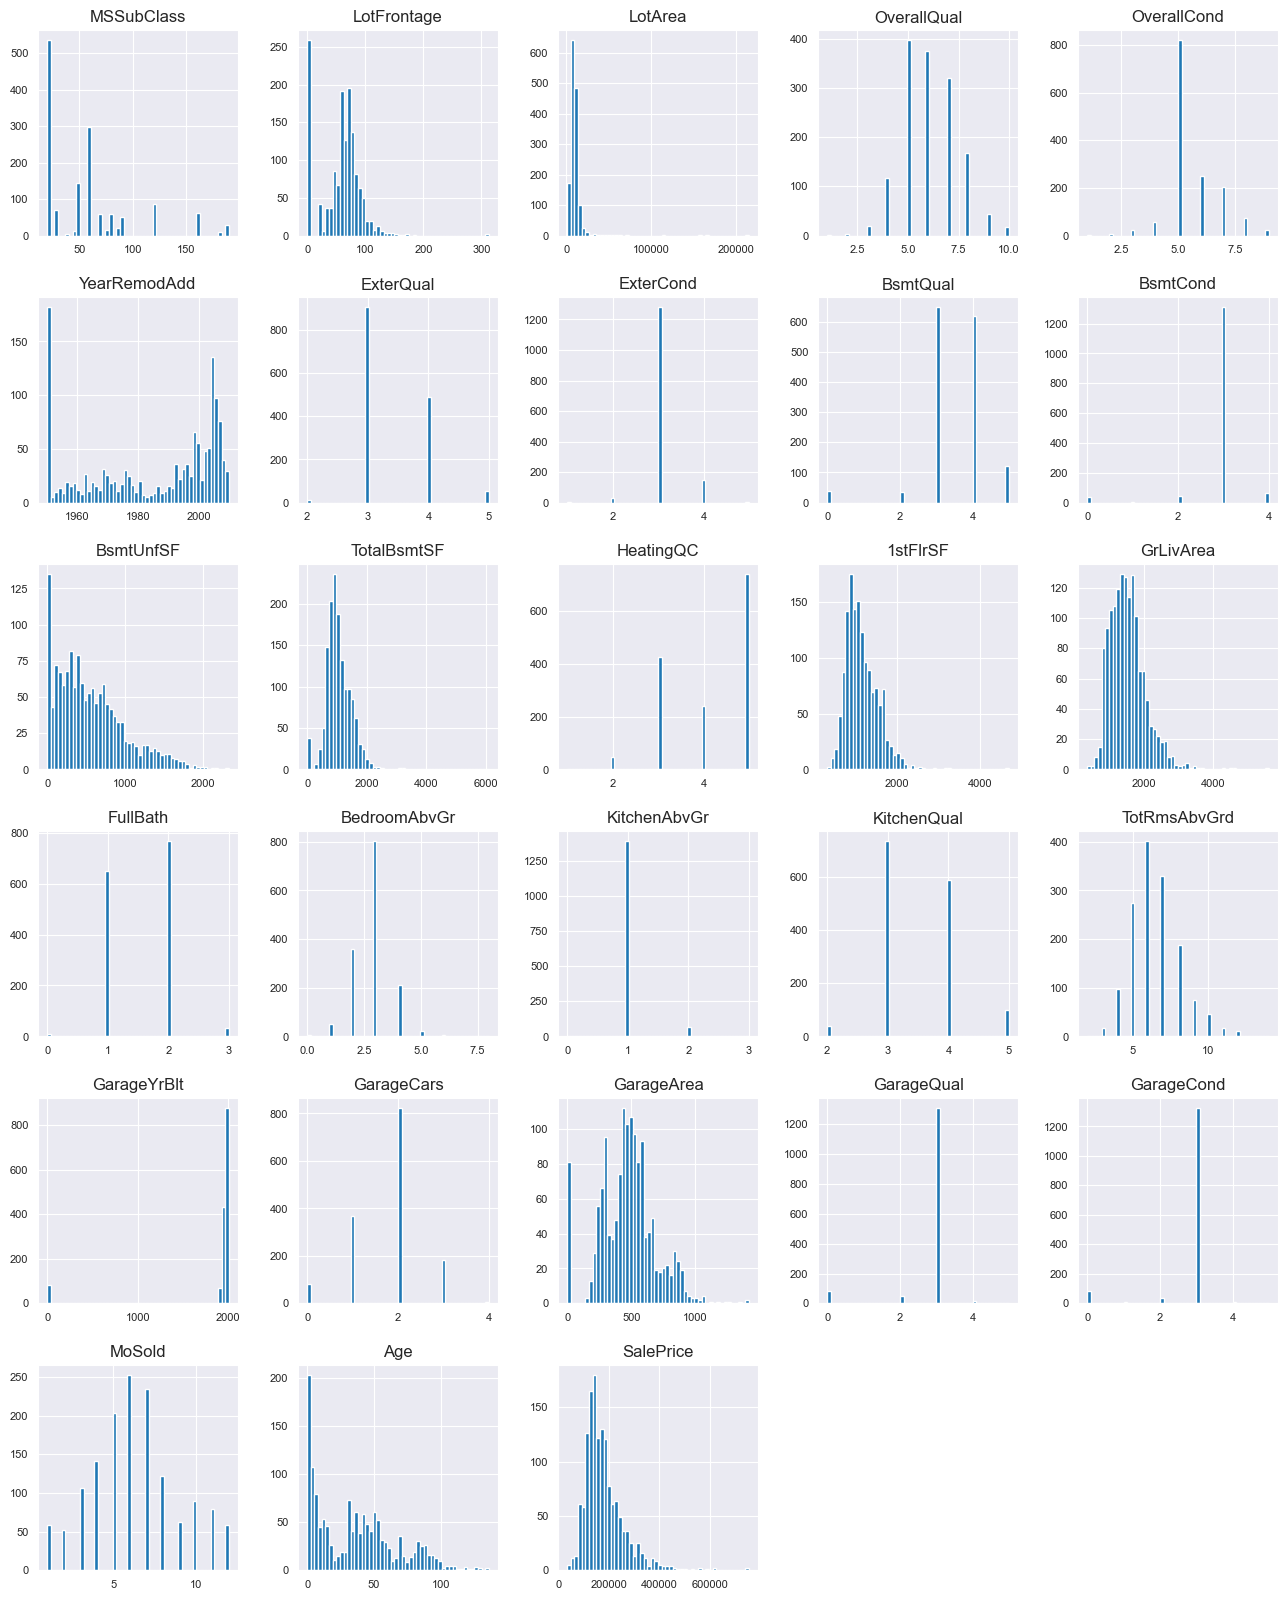

In [11]:
numerical_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

We can see that Garage Quality and condition have almost the same value, so we can drop both of them. Also the Garage Yearbuilt shows that most of
the garages have been built in the same year, therefore we can drop it too.

In [12]:
column_to_delete = ['GarageQual', 'GarageCond', 'GarageYrBlt']
numerical_data = numerical_data.drop(column_to_delete, axis=1)

This plotting is quit helpful. Even though, there are no missing data in the colums, there are data having the same value in the same colum, so we will drop these as such LowQualFunSf

In [13]:
def drop_columns_with_zero_threshold(data, threshold):
    zero_counts = (data == 0).sum()
    columns_to_drop = zero_counts[zero_counts > threshold].index
    data = data.drop(columns=columns_to_drop)
    print(zero_counts)
    return data


threshold_0 = 200
numerical_data = drop_columns_with_zero_threshold(numerical_data, threshold_0)

MSSubClass        0
LotFrontage     259
LotArea           0
OverallQual       0
OverallCond       0
YearRemodAdd      0
ExterQual         0
ExterCond         0
BsmtQual         37
BsmtCond         37
BsmtUnfSF       118
TotalBsmtSF      37
HeatingQC         0
1stFlrSF          0
GrLivArea         0
FullBath          9
BedroomAbvGr      6
KitchenAbvGr      1
KitchenQual       0
TotRmsAbvGrd      0
GarageCars       81
GarageArea       81
MoSold            0
Age              64
SalePrice         0
dtype: int64


Now let's plot again the remaining useful colums of our numerical dataset

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'ExterQual'}>,
        <Axes: title={'center': 'ExterCond'}>,
        <Axes: title={'center': 'BsmtQual'}>,
        <Axes: title={'center': 'BsmtCond'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': 'HeatingQC'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'KitchenQual'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>,
        <Axes: title={'center': 'GarageCars'}>],
       [<Axes: title={'center': 'GarageA

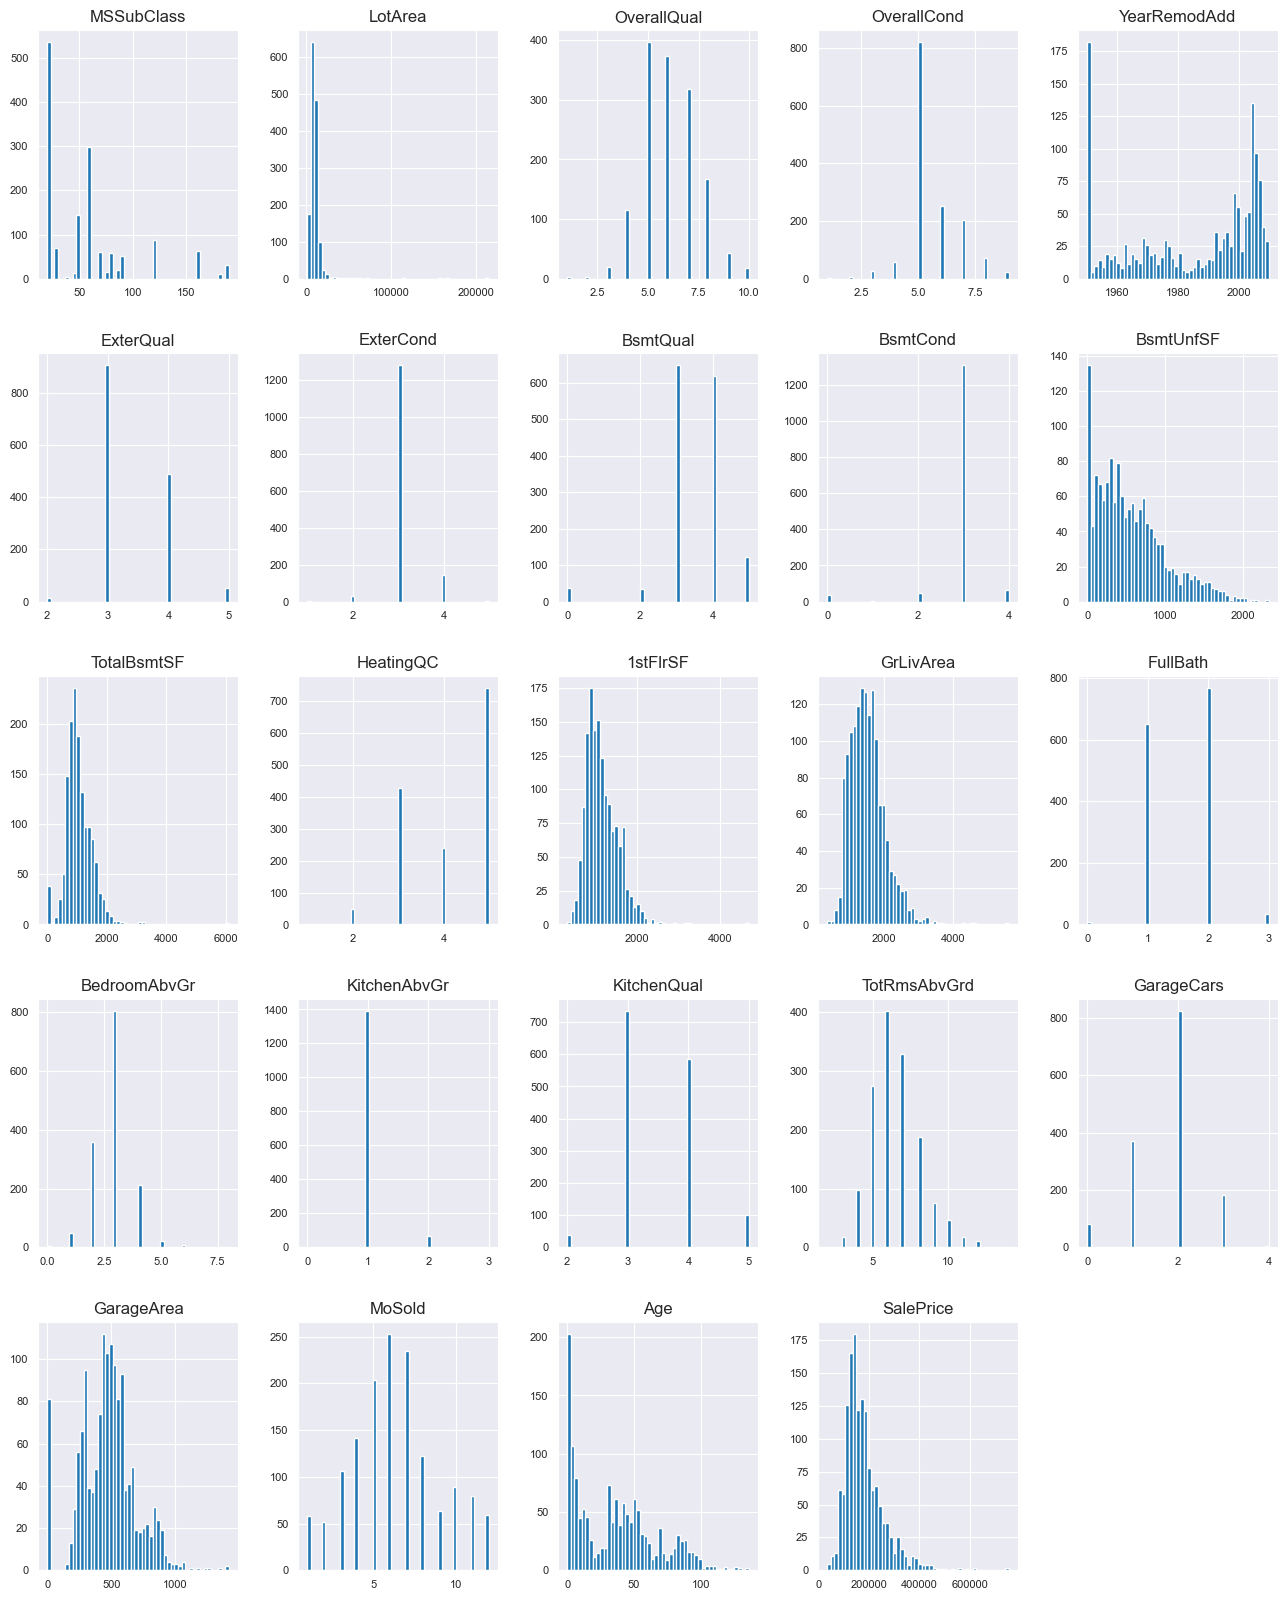

In [14]:
numerical_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

The plots looks better, but we can make it better by using logarithmic function

In [15]:
def apply_1_plus_log_transformation(data, columns_to_transform):
    transformed_data = data.copy()
    for column in columns_to_transform:
        transformed_data[column] = np.log1p(transformed_data[column])
    return transformed_data


columns_to_transform = ['1stFlrSF', 'GrLivArea', 'LotArea', 'SalePrice']
transformed_data = apply_1_plus_log_transformation(numerical_data, columns_to_transform)

In [16]:
transformed_data.head(5)

,MSSubClass,LotArea,OverallQual,OverallCond,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtUnfSF,...,FullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,Age,SalePrice
0,60,9.042040,7,5,2003,4,3,4.0,3.0,150,...,2,3,1,4,8,2,548,2,5,12.247699
1,20,9.169623,6,8,1976,3,3,4.0,3.0,284,...,2,3,1,3,6,2,460,5,31,12.109016
2,60,9.328212,7,5,2002,4,3,4.0,3.0,434,...,2,3,1,4,6,2,608,9,7,12.317171
3,70,9.164401,7,5,1970,3,3,3.0,4.0,540,...,1,3,1,4,7,3,642,2,91,11.849405
4,60,9.565284,8,5,2000,4,3,4.0,3.0,490,...,2,4,1,4,9,3,836,12,8,12.429220


Let's plot again the result after the logarithmic transformation

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'ExterQual'}>,
        <Axes: title={'center': 'ExterCond'}>,
        <Axes: title={'center': 'BsmtQual'}>,
        <Axes: title={'center': 'BsmtCond'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': 'HeatingQC'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'KitchenQual'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>,
        <Axes: title={'center': 'GarageCars'}>],
       [<Axes: title={'center': 'GarageA

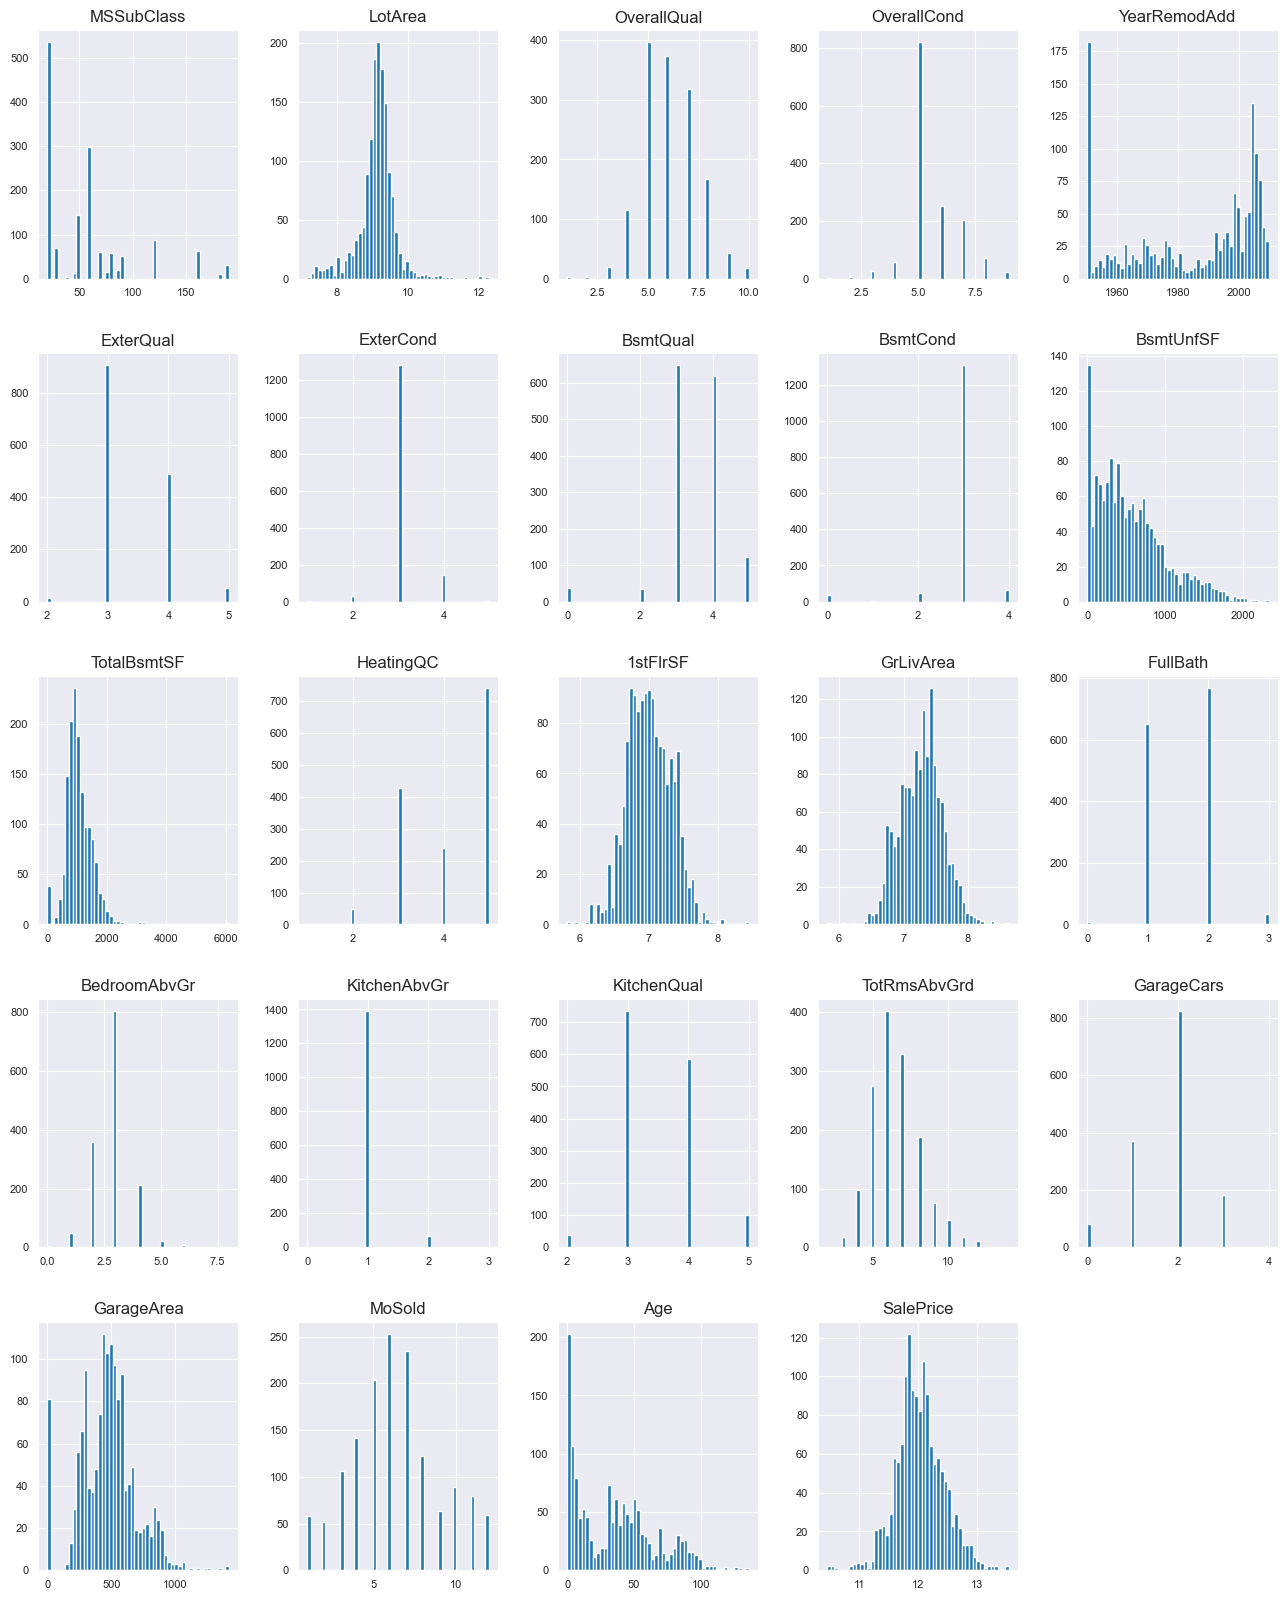

In [17]:
transformed_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

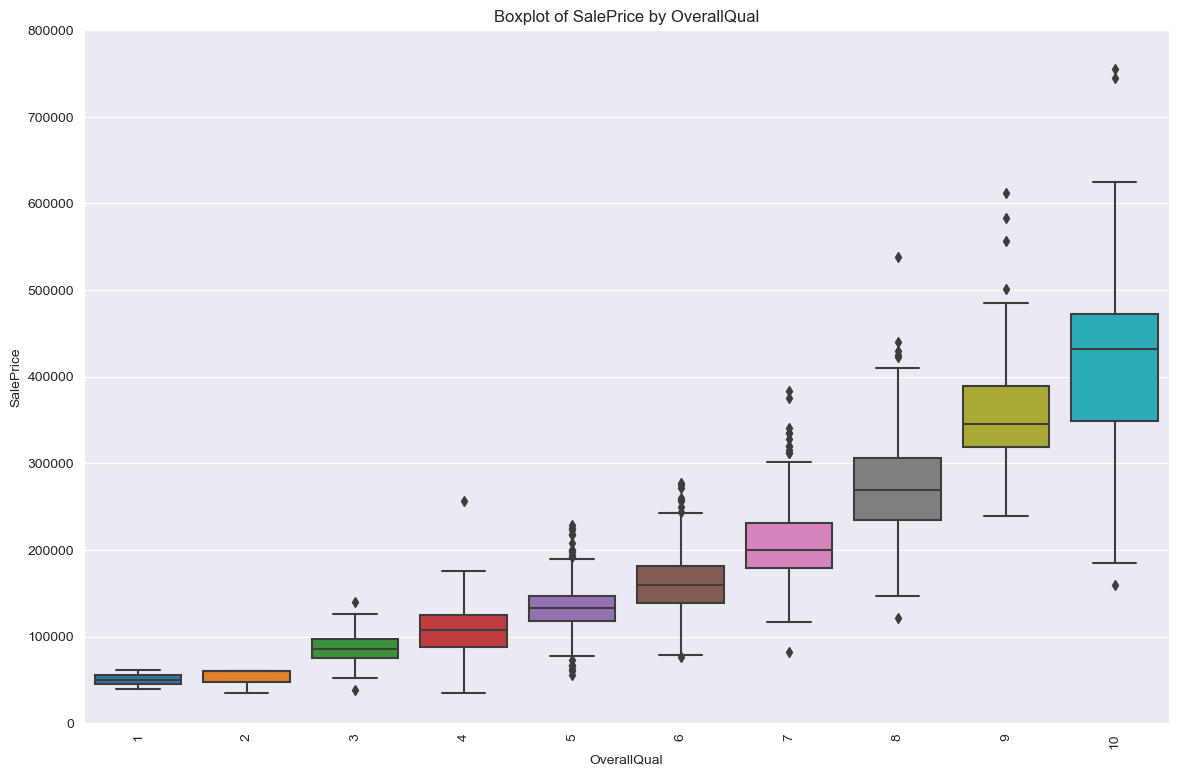

In [18]:
def plot_boxplot(df, x_column, y_column):
    data = df[[x_column, y_column]]
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.boxplot(x=x_column, y=y_column, data=data, ax=ax)
    ax.set_ylim(0, 800000)
    plt.xticks(rotation=90)
    plt.title(f'Boxplot of {y_column} by {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()


plot_boxplot(numerical_data,'OverallQual', 'SalePrice')

Box plots represent the spread of sale prices stratified by the overall quality of the properties. It is evident that higher-quality properties are yielding significantly higher sale prices. Specifically, the median sale price of properties with an overall quality rating of 10 is more than twice that of properties with a rating of 5. The median sale price of the property with a rating of 10 is 400,000,whereas the property with a rating of 5 is yielding something towards 150,000. From this, we can conclude that the overall quality of the property plays an important role in decision making and mathematical modeling.